In [37]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [17]:
%%time
train_Bag = np.vstack([np.load("train_Bag_glo_xy_mean.npy"), np.load("train_Bag_glo_xy_var.npy"),
                           np.load("train_Bag_glo_z_mean.npy"), np.load("train_Bag_glo_z_var.npy"),
                           np.load("train_Bag_pressure_change.npy")]).T

train_Hips = np.vstack([np.load("train_Hips_glo_accel_xy_mean.npy"), np.load("train_Hips_glo_accel_xy_var.npy"),
                           np.load("train_Hips_glo_accel_z_mean.npy"), np.load("train_Hips_glo_accel_z_var.npy"),
                           np.load("train_Hips_pressure_change.npy")]).T

train_Torso = np.vstack([np.load("train_Torso_glo_accel_xy_mean.npy"), np.load("train_Torso_glo_accel_xy_var.npy"),
                           np.load("train_Torso_glo_accel_z_mean.npy"), np.load("train_Torso_glo_accel_z_var.npy"),
                           np.load("train_Torso_pressure_change.npy")]).T

train_Hand = np.vstack([np.load("train_Hand_glo_accel_xy_mean.npy"), np.load("train_Hand_glo_accel_xy_var.npy"),
                           np.load("train_Hand_glo_accel_z_mean.npy"), np.load("train_Hand_glo_accel_z_var.npy"),
                           np.load("train_Hand_pressure_change.npy")]).T

Wall time: 460 ms


In [18]:
train_Label = np.load("train_Bag/train_Bag_Label.npy")
train_Label.shape

(195491, 500, 1)

In [30]:
Y = train_Label[:, 0]
Y.shape

(195491, 1)

In [31]:
train_size = int(train_Bag.shape[0] / 10) * 7
train_size

136843

In [32]:
X_train = np.vstack([train_Bag[:train_size], train_Hips[:train_size], train_Torso[:train_size], train_Hand[:train_size]])
X_train.shape

(547372, 5)

In [33]:
Y_train = np.vstack([Y[:train_size],Y[:train_size],Y[:train_size],Y[:train_size]])
Y_train.shape

(547372, 1)

In [34]:
X_test = np.vstack([train_Bag[train_size:], train_Hips[train_size:], train_Torso[train_size:], train_Hand[train_size:]])
X_test.shape

(234592, 5)

In [35]:
Y_test = np.vstack([Y[train_size:],Y[train_size:],Y[train_size:],Y[train_size:]])
Y_test.shape

(234592, 1)

In [46]:
Y_train[Y_train>=5] = 1
Y_test[Y_test>=5] = 1
np.unique(Y_train)

array([1., 2., 3., 4.])

## グリッドサーチ

In [70]:
model = xgb.XGBClassifier(max_depth=10, min_child_weight=5, gamma=0.01, colsample_bytree=0.8, subsample=1.0, n_estimators=500, learning_rate=0.075, reg_alpha=0.025)
param = {
    #"max_depth":[9,10,11], "min_child_weight":[4,5,6]
    #"gamma":[0.01, 0.05, 0.1, 0.3]
    #"subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
    #"n_estimators":[500], "learning_rate":[0.01, 0.025, 0.05, 0.075]
    "reg_alpha":[0.025, 0.05, 0.075]
}
random_index = np.random.choice(np.arange(X_train.shape[0]), int(X_train.shape[0]/10)*3, replace=False)
grid = GridSearchCV(model, param_grid=param, cv=5, n_jobs=-1, scoring='accuracy')
grid.fit(X_train[random_index], Y_train[random_index])

test_accuracy = grid.score(X_test, Y_test)
print("Best parameters: %s" % grid.best_params_)
print("Best Train Accuracy: %s" % grid.best_score_)
print("Test Accuracy: %s" % test_accuracy)

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters: {'reg_alpha': 0.025}
Best Train Accuracy: 0.8996839312263545
Test Accuracy: 0.8845783317419179


In [71]:
from mutagen.mp3 import MP3 as mp3
import pygame
import time
filename = '../mac_poteto.mp3' #再生したいmp3ファイル
pygame.mixer.init()
pygame.mixer.music.load(filename) #音源を読み込み
mp3_length = mp3(filename).info.length #音源の長さ取得
pygame.mixer.music.play(1) #再生開始。1の部分を変えるとn回再生(その場合は次の行の秒数も×nすること)
time.sleep(mp3_length + 0.25) #再生開始後、音源の長さだけ待つ(0.25待つのは誤差解消)
pygame.mixer.music.stop() #音源の長さ待ったら再生停止

## 訓練して、trainデータの後半をテストデータとして、評価

In [72]:
model = xgb.XGBClassifier(max_depth=10, min_child_weight=5, gamma=0.01, colsample_bytree=0.8, subsample=1.0, n_estimators=500, learning_rate=0.075, reg_alpha=0.025)
model.fit(X_train, Y_train)

predict = model.predict(X_test)

NameError: name 'cofusion_matrix' is not defined

In [76]:
cm = confusion_matrix(Y_test, predict)
cm

array([[162026,    615,      3,   1840],
       [  2583,  21527,    721,   6421],
       [    15,    653,   9815,    437],
       [  4219,   7146,   1665,  14906]], dtype=int64)

In [77]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predict)
accuracy

0.8878137361887873

In [80]:
from sklearn.metrics import f1_score
f1_macro = f1_score(Y_test, predict, average='macro')
f1_micro = f1_score(Y_test, predict, average='micro')
f1_macro, f1_micro

(0.7757694441553417, 0.8878137361887873)

## feature_importance
### f0:加速度xy平均、f1:加速度xy分散、f2:加速度z平均、f3:加速度z分散、f4:気圧変化量

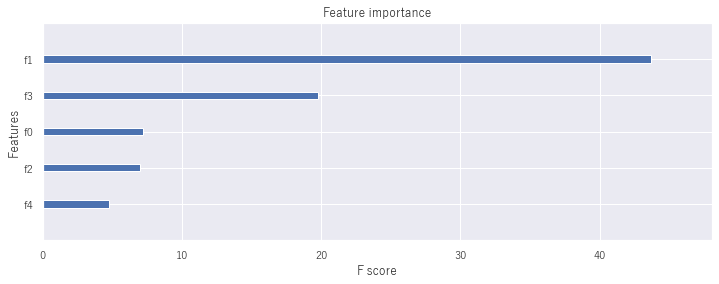

In [82]:
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)

## trainデータに対する評価も確認してみる

In [83]:
train_predict = model.predict(X_train)
cm = confusion_matrix(Y_train, train_predict)
cm

array([[389033,    774,      7,   2718],
       [  4481,  51750,    392,   9733],
       [    44,    719,  21748,    269],
       [  9664,  11747,    522,  43771]], dtype=int64)

In [84]:
accuracy = accuracy_score(Y_train, train_predict)
accuracy

0.9249687598196473

In [85]:
f1_macro = f1_score(Y_train, train_predict, average='macro')
f1_macro

0.8598020352063825

# ここからValidationデータで検証

In [93]:
%%time

import pickle

with open("validation_Bag.binaryfile", 'rb') as f:
    val_Bag = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]
    
with open("validation_Hips.binaryfile", 'rb') as f:
    val_Hips = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

with open("validation_Torso.binaryfile", 'rb') as f:
    val_Torso = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

with open("validation_Hand.binaryfile", 'rb') as f:
    val_Hand = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

val_Bag.shape

Wall time: 2min 51s


(28685, 500, 5)

In [94]:
def val_Preprocess(x):
    label = x[:, 0, 0]
    label = label[:, 0]
    x_xy = np.sqrt(np.square(x[:, :, 1].copy()) + np.square(x[:, :, 2].copy()))
    x_xy_mean = np.mean(x_xy.copy(), axis=1)
    x_xy_var = np.var(x_xy.copy(), axis=1)
    x_z_mean = np.mean(x[:, :, 3].copy(), axis=1)
    x_z_var = np.var(x[:, :, 3].copy(), axis=1)
    x_pressure_change = x[:, -1, 4] - x[:, 0, -1]
    result = np.vstack([label, x_xy_mean, x_xy_var, x_z_mean, x_z_var, x_pressure_change]).T
    return result

In [95]:
val_Bag = val_Preprocess(val_Bag)
val_Hips = val_Preprocess(val_Hips)
val_Torso = val_Preprocess(val_Torso)
val_Hand = val_Preprocess(val_Hand)
val_Hand.shape

(28685, 6)

In [97]:
val_Bag[:, 0].shape

(28685,)

In [96]:
X_val = np.vstack([val_Bag[:, 1:], val_Hips[:, 1:], val_Torso[:, 1:], val_Hand[:, 1:]])
X_val.shape

((114740, 5), (4, 28685))

In [100]:
Y_val = np.hstack([val_Bag[:, 0], val_Bag[:, 0], val_Bag[:, 0], val_Bag[:, 0]])
Y_val.shape

(114740,)

In [101]:
Y_val[Y_val >=5] = 1
np.unique(Y_val)

array([1., 2., 3., 4.])

In [102]:
val_predict = model.predict(X_val)

In [103]:
cm = confusion_matrix(Y_val, val_predict)
cm

array([[81585,   193,    50,   348],
       [ 5892,  9115,    14,  5739],
       [   40,   949,   596,   619],
       [ 7228,  1070,     1,  1301]], dtype=int64)

In [104]:
accuracy = accuracy_score(Y_val, val_predict)
accuracy

0.8070158619487537

In [105]:
f1_macro = f1_score(Y_val, val_predict, average='macro')
f1_macro

0.5135642210585022